In [1]:
from __future__ import division, print_function
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import imgaug as ia
import operator
import functools
import random
from PIL import Image
from imgaug import augmenters as iaa
plt.rcParams['image.cmap'] = 'gray'
np.random.seed(98765)


In [2]:
from tf_unet import image_gen
from tf_unet import unet
from tf_unet import util
from tf_unet.image_util import ImageDataProvider

In [11]:
POS_EPOCHS = 10
NEG_EPOCHS = 1
PATCH_SIZE = 192
MARGIN = 20
DISCREET_MASK = True

In [4]:
def randomCrop(img, mask, width, height):
    assert img.shape[0] >= width
    assert img.shape[1] >= height
    assert img.shape[0] == mask.shape[0]
    assert img.shape[1] == mask.shape[1]
    x = random.randint(0, img.shape[0] - width)
    y = random.randint(0, img.shape[1] - height)
    img = img[x:x+width, y:y+height]
    mask = mask[x:x+width, y:y+height]
    return img, mask, x, y

In [5]:
# Define augmentation
def do_augment_data(data, labels, flip_ud=True):
    image = data
    mask = labels
    
    flip_ud_prob = 0
    if (flip_ud == True):
        flip_ud_prob = 0.5
    
    # more aggressive augmentation:
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Flipud(flip_ud_prob),
        iaa.Crop(percent=(0, 0.05)),
        iaa.Affine(
            scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
            translate_percent={"x": (-0.01, 0.01), "y": (-0.01, 0.01)},
            rotate=(-4, 4),
            shear=(-2, 2)
        )
    ], random_order = True)

    seq_det = seq.to_deterministic()

    image_aug = seq_det.augment_image(image)
    mask_aug = seq_det.augment_image(mask)

    if (DISCREET_MASK == True):
        # augmentation makes some of these values not discreet, fix them here.
        mask_aug[mask_aug > 0.5] = 1
        mask_aug[mask_aug <= 0.5] = 0
            
    return image_aug, mask_aug

In [6]:
# Create a generator that uses the Image data provider

class GrayImageDataProvider(ImageDataProvider):
    def __init__(self, search_path, a_min=None, a_max=None, data_suffix=".png", mask_suffix='_mask.png', shuffle_data=True, augment_data=False, flip_ud=True):
        self.augment_data = augment_data
        self.flip_ud = flip_ud
        super(GrayImageDataProvider, self).__init__(search_path, a_min, a_max, data_suffix, mask_suffix, shuffle_data)

    def _load_file(self, path, dtype=np.float32):
        #im = equalize(Image.open(path).convert('L'))
        im = Image.open(path).convert('L')
        return np.array(im, dtype)
    
    def _post_process(self, data, labels):
        if (self.augment_data):
            data_aug, labels_aug = do_augment_data(data, labels, self.flip_ud)
        else:
            data_aug, labels_aug = data, labels
        return data_aug, labels_aug;

In [7]:
class CropDataProvider(GrayImageDataProvider):
    def __init__(self, search_path, augment_data=False, size=PATCH_SIZE, only_positive=False, crop_first=True):
        self.size = size
        self.only_positive = only_positive
        self.crop_first = crop_first
        super(CropDataProvider, self).__init__(search_path, augment_data=augment_data, flip_ud=True)
    
    def _post_process(self, data, labels):
        if (self.crop_first == True):
            while(True):
                cropped_data, cropped_labels, x_offset, y_offset = randomCrop(data, labels, self.size, self.size)

                if(self.only_positive == True):
                    if (not [0,1] in cropped_labels[MARGIN:-MARGIN, MARGIN:-MARGIN]):
                        continue

                return super(CropDataProvider, self)._post_process(cropped_data, cropped_labels)
        else:
            while(True):
                data_aug, labels_aug = super(CropDataProvider, self)._post_process(data, labels)
                cropped_data, cropped_labels, x_offset, y_offset = randomCrop(data_aug, labels_aug, self.size, self.size)           
                
                if(self.only_positive == True):
                    if (not [0,1] in cropped_labels[MARGIN:-MARGIN, MARGIN:-MARGIN]):
                        continue
                return cropped_data, cropped_labels
    
    def _next_data(self):
        while(True):
            img, label = super(CropDataProvider, self)._next_data()
            if(self.only_positive == True and np.amax(label) == False):
                continue
            return img, label
                
    

Number of files used: 26
Number of channels: 1
Number of classes: 2


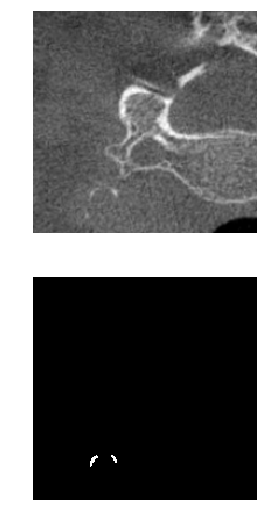

In [9]:
# visualize one of the files
generator = CropDataProvider("../_data/localizer_training/positive/*.png", augment_data=True, size=PATCH_SIZE, only_positive=False, crop_first=False)
x_test, y_test = generator(1)

fig, ax = plt.subplots(2,1, sharey=True, figsize=(4,9))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")

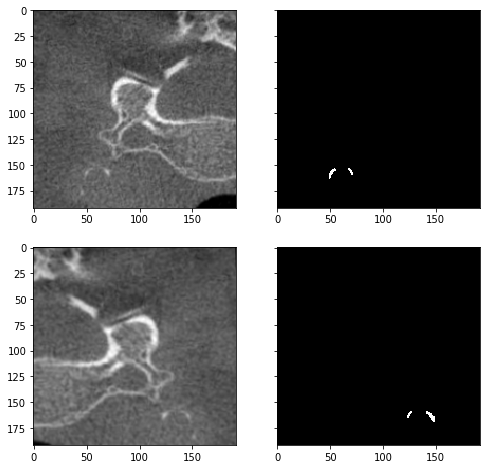

In [10]:
# visualize the augmentation

image = x_test[0,...,0]
mask = y_test[0,...,1]

image_aug, mask_aug = do_augment_data(image, mask)

fig, ax = plt.subplots(2,2, sharey=True, figsize=(8,8))
ax[0, 0].imshow(image, aspect="auto")
ax[1, 0].imshow(image_aug, aspect="auto")
ax[0, 1].imshow(mask, aspect="auto")
ax[1, 1].imshow(mask_aug, aspect="auto")

In [12]:
# Train the model

generator = CropDataProvider("../_data/localizer_training/positive/*.png", augment_data=True, size=PATCH_SIZE, only_positive=True, crop_first=True)
net = unet.Unet(channels=generator.channels, n_class=generator.n_class, layers=3, features_root=32)
trainer = unet.Trainer(net, optimizer="adam", verification_batch_size = 8)
path = trainer.train(generator, "./unet_trained", training_iters=32, epochs=POS_EPOCHS, display_step=16)

2019-11-05 23:26:05,433 Layers 3, features 32, filter size 3x3, pool size: 2x2


Number of files used: 26
Number of channels: 1
Number of classes: 2
Instructions for updating:
Colocations handled automatically by placer.


2019-11-05 23:26:05,461 From /Users/nsemsarilar/code/dl/venv2/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2019-11-05 23:26:05,485 From /Users/nsemsarilar/code/dl/tf_unet/tf_unet/layers.py:39: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2019-11-05 23:26:06,900 Removing '/Users/nsemsarilar/code/dl/tf_unet/localizer/prediction'
2019-11-05 23:26:06,925 Removing '/Users/nsemsarilar/code/dl/tf_unet/localizer/unet_trained'
2019-11-05 23:26:06,928 Allocating '/Users/nsemsarilar/code/dl/tf_unet/localizer/prediction'
2019-11-05 23:26:06,930 Allocating '/Users/nsemsarilar/code/dl/tf_unet/localizer/unet_trained'
2019-11-05 23:26:09,749 Verification error= 0.2%, loss= 0.6728
2019-11-05 23:26:10,097 Start optimization
2019-11-05 23:26:11,367 Iter 0, Minibatch Loss= 0.5875, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-11-05 23:26:21,699 Iter 16, Minibatch Loss= 0.0337, Training Accuracy= 0.9972, Minibatch 

In [13]:
# Continued training (restore, use both negative and positive values)

negGenerator = CropDataProvider("../_data/localizer_training/all/*.png", augment_data=True, size=PATCH_SIZE, only_positive=False, crop_first=True)
net = unet.Unet(channels=negGenerator.channels, n_class=negGenerator.n_class, layers=3, features_root=32)
trainer = unet.Trainer(net, optimizer="adam", verification_batch_size = 8)
path = trainer.train(negGenerator, "./unet_trained", restore=True, training_iters=32, epochs=NEG_EPOCHS, display_step=16)


2019-11-05 23:30:29,866 Layers 3, features 32, filter size 3x3, pool size: 2x2


Number of files used: 34
Number of channels: 1
Number of classes: 2
Instructions for updating:
Use standard file APIs to check for files with this prefix.


2019-11-05 23:30:31,541 From /Users/nsemsarilar/code/dl/venv2/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from ./unet_trained/model.ckpt


2019-11-05 23:30:31,543 Restoring parameters from ./unet_trained/model.ckpt
2019-11-05 23:30:31,667 Model restored from file: ./unet_trained/model.ckpt
2019-11-05 23:30:34,355 Verification error= 0.0%, loss= 0.0172
2019-11-05 23:30:34,725 Start optimization
2019-11-05 23:30:36,421 Iter 0, Minibatch Loss= 0.0146, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-11-05 23:30:47,688 Iter 16, Minibatch Loss= 0.0000, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-11-05 23:30:57,906 Epoch 0, Average loss: 0.0044, learning rate: 0.0010
2019-11-05 23:31:00,329 Verification error= 0.0%, loss= 0.0004
2019-11-05 23:31:00,820 Optimization Finished!
